In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def prepare_stem_score():
    stem_score = pd.read_csv('../data/TCGA-TARGET-GTEx/mRNA_StemScore.tsv', sep='\t', index_col=0, header=None)
    stem_score.columns = ['mRNAsi']
    stem_score.index.name = 'id'
    
    tcga_info = pd.read_csv('../data/TCGA-TARGET-GTEx/TCGA_mapping.txt', sep='\t', header=0)
    gtex_info = pd.read_csv('../data/TCGA-TARGET-GTEx/GTEx_mapping.txt', sep='\t', header=0)
    gtex_info = gtex_info.set_index('submitted_sample_id_s')
    
    stem_score['cohort'] = stem_score.index.str.split('-', n=1).str[0]
    stem_score['tissue_status'] = np.nan
    stem_score.loc[stem_score['cohort'] == 'GTEX', 'tissue_status'] = 'Normal'
    # drop tumor samples from gtex
    gtex_tumor_id = np.intersect1d(gtex_info[gtex_info['is_tumor_s'] == 'Yes'].index, stem_score.index)
    stem_score = stem_score.drop(gtex_tumor_id, axis=0)
    
    cond_01 = stem_score.index.str.startswith('TCGA') & stem_score.index.str.endswith('01')
    cond_11 = stem_score.index.str.startswith('TCGA') & stem_score.index.str.endswith('11')
    stem_score.loc[cond_01, 'tissue_status'] = 'Tumor'
    stem_score.loc[cond_11, 'tissue_status'] = 'PNT'
    
    # remove non Tumor nor PNT samples
    stem_score = stem_score.dropna(axis=0)
    
    # set body site for GTEx
    ids = np.intersect1d(gtex_info.index, stem_score.index)
    stem_score['t'] = np.nan
    stem_score.loc[ids, 'body_site'] = gtex_info.loc[ids, 'body_site_s']
    
    # set body site for TCGA
    tcga_info['short_id'] = tcga_info['barcode'].str.rsplit('-', 3).str[0].str[:-1]
    tcga_info = tcga_info.drop_duplicates('short_id')
    tcga_info = tcga_info.set_index('short_id')
    ids = np.intersect1d(tcga_info.index, stem_score.index)
    stem_score['disease'] = np.nan
    stem_score.loc[ids, 'disease'] = tcga_info.loc[ids, 'disease']
    
    disease_tissue_dic = {'LGG': 'Brain', 'LIHC': 'Liver', 'CESC': 'Cervix', 'LUAD': 'Lung',
                      'COAD': 'Colon', 'BRCA': 'Breast', 'TGCT': 'Testis', 'SARC': np.nan,
                      'KIRP': 'Kidney', 'STAD': 'Stomach', 'PRAD': 'Prostate', 'ESCA': 'Esophagus',
                      'HNSC': np.nan, 'GBM': 'Brain', 'KIRC': 'Kidney', 'UCEC': 'Uterus',
                      'THYM': 'Thymus', 'BLCA': 'Bladder', 'LUSC': 'Lung', 'THCA': 'Thyroid',
                      'MESO': np.nan, 'READ': 'Rectum', 'PAAD': 'Pancreas', 'OV': 'Ovary',
                      'PCPG': np.nan, 'SKCM': 'Skin', 'UVM': np.nan, 'UCS': 'Uterus',
                      'KICH': 'Kidney', 'DLBC': 'Whole Blood', 'ACC': 'Adrenal Gland', 'CHOL': np.nan }
    stem_score['tissue'] = stem_score['body_site']
    stem_score['body_site'] = np.nan
    stem_score['body_site'] = stem_score['tissue'].str.split(' - ').str[0] 
    stem_score.loc[stem_score['cohort'] == 'TCGA', 'body_site'] = stem_score.loc[stem_score['cohort'] == 'TCGA', 'disease'].apply(lambda x: disease_tissue_dic[x])
    return stem_score

In [120]:
def prepare_stem_score2():
    tcga_info = pd.read_csv('../data/TCGA-TARGET-GTEx/TCGA_mapping.txt', sep='\t', header=0)
    gtex_info = pd.read_csv('../data/GTEx/GTEx_tissueID_information.txt', sep='\t', header=0)
    gtex_info = gtex_info.set_index('SAMPID')
    gtex_info.index = gtex_info.index.str.replace('_', '-')
    # GTEx
    g_stem_score = pd.read_csv('../data/GTEx/GTEx.counts.mRNA_StemScore.tsv', sep='\t', index_col=0, header=None)
    g_stem_score.columns = ['mRNAsi']
    g_stem_score.index.name = 'id'

    g_ereg_score = pd.read_csv('../data/GTEx/GTEx.counts.EREG-mRNA_StemScore.tsv', sep='\t', index_col=0, header=None)
    g_ereg_score.columns = ['EREG-mRNAsi']
    g_ereg_score.index.name = 'id'

    g_stem_score = pd.concat([g_stem_score, g_ereg_score], axis=1)

    #TCGA
    t_stem_score = pd.read_excel('../data/paper/TCGA_stemness.xlsx', sheet=0, index_col=0, header=0)


    stem_score = pd.concat([g_stem_score, t_stem_score], axis=0)

    stem_score.columns = ['EREG-mRNAsi', 'disease', 'mRNAsi', 'tissue_status']
    stem_score['cohort'] = stem_score.index.str.split('-', n=1).str[0]
    stem_score.loc[stem_score['cohort'] == 'GTEX', 'tissue_status'] = 'Normal'

    stem_score.loc[stem_score['tissue_status'] == 1, 'tissue_status'] = 'Tumor'
    stem_score.loc[stem_score['tissue_status'] == 11, 'tissue_status'] = 'PNT'
    stem_score = stem_score[(stem_score['tissue_status'] == 'Tumor') | 
                            (stem_score['tissue_status'] == 'PNT') | 
                            (stem_score['tissue_status'] == 'Normal')]

    # set body site for GTEx
    ids = np.intersect1d(gtex_info.index, stem_score.index)
    stem_score['body_site'] = np.nan
    stem_score['tissue'] = np.nan
    stem_score.loc[ids, 'body_site'] = gtex_info.loc[ids, 'SMTS']
    stem_score.loc[ids, 'tissue'] = gtex_info.loc[ids, 'SMTSD']

    disease_tissue_dic = {'LGG': 'Brain', 'LIHC': 'Liver', 'CESC': 'Cervix', 'LUAD': 'Lung',
                      'COAD': 'Colon', 'BRCA': 'Breast', 'TGCT': 'Testis', 'SARC': np.nan,
                      'KIRP': 'Kidney', 'STAD': 'Stomach', 'PRAD': 'Prostate', 'ESCA': 'Esophagus',
                      'HNSC': np.nan, 'GBM': 'Brain', 'KIRC': 'Kidney', 'UCEC': 'Uterus',
                      'THYM': 'Thymus', 'BLCA': 'Bladder', 'LUSC': 'Lung', 'THCA': 'Thyroid',
                      'MESO': np.nan, 'READ': 'Rectum', 'PAAD': 'Pancreas', 'OV': 'Ovary',
                      'PCPG': np.nan, 'SKCM': 'Skin', 'UVM': np.nan, 'UCS': 'Uterus',
                      'KICH': 'Kidney', 'DLBC': 'Blood', 'ACC': 'Adrenal Gland', 'CHOL': np.nan, np.nan: np.nan }
    stem_score.loc[stem_score['cohort'] == 'TCGA', 'body_site'] = stem_score.loc[stem_score['cohort'] == 'TCGA', 'disease'].apply(lambda x: disease_tissue_dic[x])
    stem_score = stem_score.loc[:, ['mRNAsi', 'EREG-mRNAsi', 'cohort', 'tissue_status', 'body_site', 'disease', 'tissue']]
    stem_score.loc[:, ['mRNAsi', 'EREG-mRNAsi']].astype('float64')
    return stem_score

In [121]:
stem_score = prepare_stem_score2()

/home/omics/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [10]:
stem_score = pd.read_csv('../data/TCGA-TARGET-GTEx/mRNA_StemScore.tsv', sep='\t', header=None, index_col=0, names=['id', 'mRNAsi'])

In [11]:
gtex_score = pd.read_csv('../data/GTEx/GTEx.counts.mRNA_StemScore.tsv', sep='\t', header=None, index_col=0, names=['id', 'mRNAsi'])

In [14]:
paper_score = pd.read_excel('../data/paper/TCGA_stemness.xlsx')
paper_score['TCGAshort.id'] = paper_score['TCGAlong.id'].str.rsplit('-', 3).str[0].str[:-1]
paper_score = paper_score.drop_duplicates('TCGAshort.id')
paper_score = paper_score.set_index('TCGAshort.id')

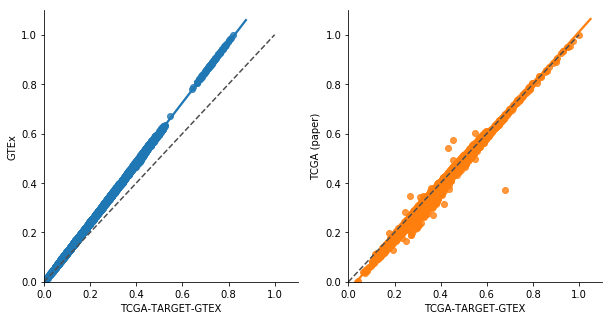

In [16]:
# check consistency
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, df in zip(range(2), [gtex_score, paper_score]):
    idx = np.intersect1d(stem_score.index, df.index)
    sns.regplot(stem_score.loc[idx, 'mRNAsi'].values, df.loc[idx, 'mRNAsi'].values, ax=axes[i])
    axes[i].set_xlim(0, 1.1)
    axes[i].set_ylim(0, 1.1)
    axes[i].plot([0, 1], [0, 1], ls="--", c=".3")
    axes[i].set_xlabel('TCGA-TARGET-GTEX')
axes[0].set_ylabel('GTEx')
axes[1].set_ylabel('TCGA (paper)')
sns.despine()
fig.savefig('../data/Analysis/dataset-consistency/check_mRNAsi_consistency.png')
fig.savefig('../data/Analysis/dataset-consistency/check_mRNAsi_consistency.pdf')

In [3]:
stem_score = pd.read_csv('../data/TCGA-TARGET-GTEx/mRNA_StemScore.extended.tsv', sep='\t', header=0, index_col=0)

/home/omics/miniconda2/lib/python2.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/omics/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/omics/miniconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


TypeError: 'float' object is not iterable

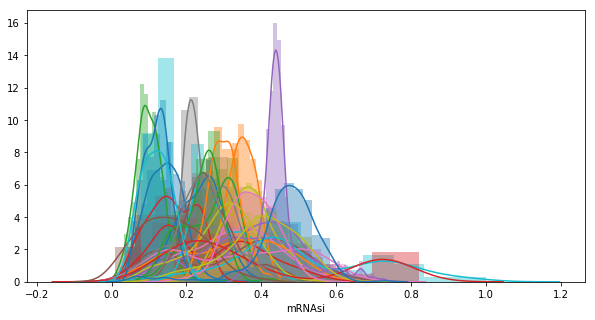

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=stem_score[stem_score['cohort'] == 'GTEX'], x='body_site', y='mRNAsi', ax=ax)
plt.xticks(rotation=60)
fig.savefig('../data/Analysis/mRNAsi-bodysite/mRNAsi_GTEx_all_bodysite_distribution_boxplot.pdf')
fig.savefig('../data/Analysis/mRNAsi-bodysite/mRNAsi_GTEx_all_bodysite_distribution_boxplot.png')

In [19]:
grouped = stem_score.groupby('body_site')
count_df = grouped.count()
sites = count_df[(count_df['disease'] > 50) & (count_df['tissue'] > 50)].index

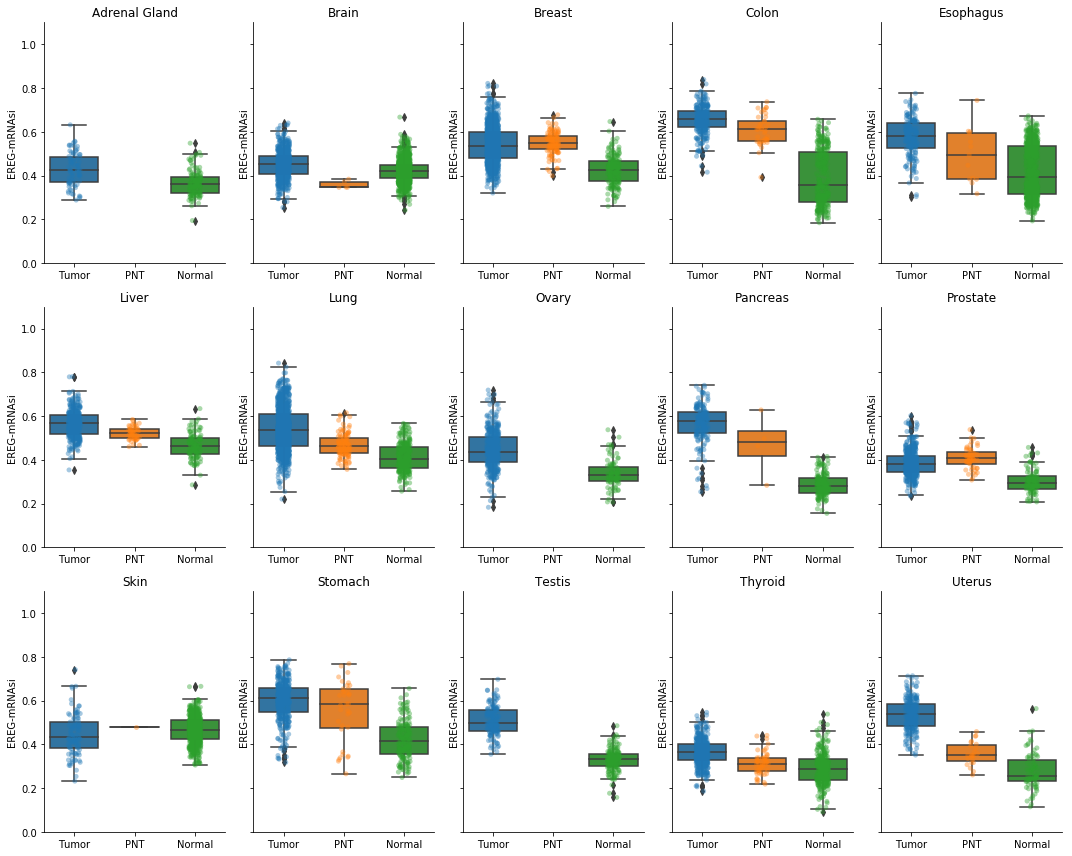

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 12), sharey=True)
axes = axes.flatten()
for i in range(len(sites)):
    tmp = stem_score[stem_score['body_site'] == sites[i]]
    sns.boxplot(data=tmp, x='tissue_status', y='EREG-mRNAsi', ax=axes[i], order=['Tumor', 'PNT', 'Normal'])
    sns.stripplot(data=tmp, x='tissue_status', y='EREG-mRNAsi', alpha=0.4, ax=axes[i], order=['Tumor', 'PNT', 'Normal'])
    axes[i].set_ylim(0, 1.1)
    axes[i].set_title(sites[i])
    # Hide the right and top spines
    axes[i].set_xlabel('')
sns.despine()
fig.tight_layout()

In [21]:
fig.savefig('../data/Analysis/mRNAsi-bodysite/20181004/TOIL.EREG-mRNAsi_by_BodySite.png')
fig.savefig('../data/Analysis/mRNAsi-bodysite/20181004/TOIL.EREG-mRNAsi_by_BodySite.pdf')

In [22]:
grouped = stem_score.groupby(['body_site', 'tissue_status'])
count_df = grouped.count()
sites = []
for site in stem_score['body_site'].unique():
    try:
        if (count_df.loc[site, 'mRNAsi'] > 10).all() and count_df.loc[site, 'mRNAsi'].shape[0] == 3:
            sites.append(site)
    except TypeError:
        pass

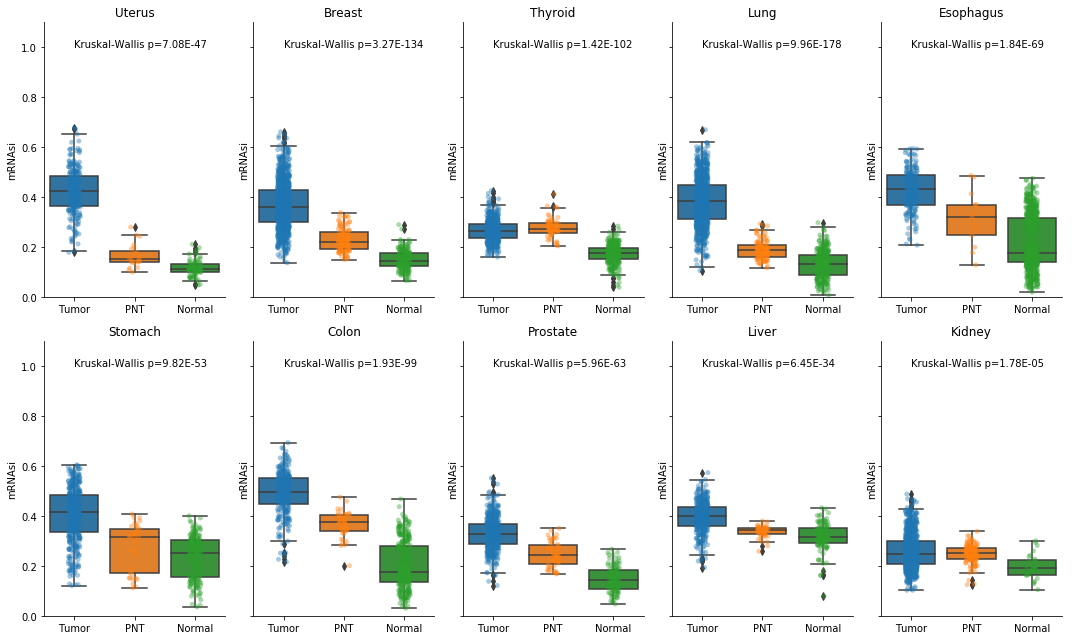

In [27]:
from scipy.stats import f_oneway, kruskal

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 9), sharey=True)
axes = axes.flatten()
for i in range(len(sites)):
    tmp = stem_score[stem_score['body_site'] == sites[i]]
    grouped = tmp.groupby('tissue_status').groups
    f, p = kruskal(tmp.loc[grouped['Tumor'], 'mRNAsi'], 
                    tmp.loc[grouped['PNT'], 'mRNAsi'], 
                    tmp.loc[grouped['Normal'], 'mRNAsi'])
    sns.boxplot(data=tmp, x='tissue_status', y='mRNAsi', ax=axes[i], order=['Tumor', 'PNT', 'Normal'])
    sns.stripplot(data=tmp, x='tissue_status', y='mRNAsi', alpha=0.4, ax=axes[i], order=['Tumor', 'PNT', 'Normal'])
    axes[i].text(0, 1, 'Kruskal-Wallis p={:.2E}'.format(p))
    axes[i].set_ylim(0, 1.1)
    axes[i].set_title(sites[i])
    # Hide the right and top spines
    axes[i].set_xlabel('')
sns.despine()
fig.tight_layout()

In [28]:
fig.savefig('../data/Analysis/mRNAsi-bodysite/20181004/TOIL.mRNAsi_by_BodySite_kruskal.png')
fig.savefig('../data/Analysis/mRNAsi-bodysite/20181004/TOIL.mRNAsi_by_BodySite_kruskal.pdf')

In [129]:
stem_score.to_csv('../data/GTEx-TCGA.mRNA_StemScore.extended.tsv', sep='\t')